In [26]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 8


import sklearn
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing


# Tratamiento de datos

In [3]:
import pandas as pd
df = pd.read_excel("Tabla TFG Maria v2.xlsx")
df.head()

,POPULATION,x5,x10,x1,x2,x9,x3,x11,x4,x6,x7,x8,x12,x14
0,TRAIN,710 to 718_0,150 to 1E15_0,60000 to 1E15_0,0.35 to 0.7_1,-1E15 to 1_0,50 to 75_0,1 to 1E15_0,-1E15 to 111_1,0.0,1.0,0.0,0,5.094849
1,TEST,627 to 710_0,150 to 1E15_0,60000 to 1E15_0,0.35 to 0.7_1,1 to 1E15_0,50 to 75_0,1 to 1E15_0,-1E15 to 111_1,0.0,1.0,0.0,1,5.106910
2,TRAIN,627 to 710_0,150 to 1E15_0,60000 to 1E15_0,0.35 to 0.7_1,1 to 1E15_0,50 to 75_0,1 to 1E15_0,-1E15 to 111_1,0.0,1.0,0.0,1,5.106944
3,TRAIN,627 to 710_0,-2100 to 150_0,60000 to 1E15_0,0.35 to 0.7_1,-1E15 to 1_0,50 to 75_0,-1E15 to 1_1,-1E15 to 111_1,0.0,1.0,0.0,1,5.269766
4,TEST,729 to 733_0,-2100 to 150_0,60000 to 1E15_0,0.7 to 0.9_0,-1E15 to 1_0,80 to 1E15_1,-1E15 to 1_1,-1E15 to 111_1,0.0,1.0,0.0,0,5.075245


In [4]:
# Filtramos los datos en función de la columna "Population"
df_train = df[df["POPULATION"] == "TRAIN"]
df_test = df[df["POPULATION"] == "TEST"]

In [5]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15470 entries, 0 to 22092
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   POPULATION  15470 non-null  object 
 1   x5          15470 non-null  object 
 2   x10         15470 non-null  object 
 3   x1          15470 non-null  object 
 4   x2          15470 non-null  object 
 5   x9          15470 non-null  object 
 6   x3          15470 non-null  object 
 7   x11         15470 non-null  object 
 8   x4          15470 non-null  object 
 9   x6          15465 non-null  float64
 10  x7          15237 non-null  float64
 11  x8          15465 non-null  float64
 12  x12         15470 non-null  int64  
 13  x14         15470 non-null  float64
dtypes: float64(4), int64(1), object(9)
memory usage: 1.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6623 entries, 1 to 22091
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --

In [6]:
#Eliminamos missing
df_train = df_train.dropna()
df_test = df_test.dropna()

## Creción dummies y variables numéricas

In [7]:
dummies_train = pd.get_dummies(df_train[['x5', 'x10', 'x1', 'x2', 'x9', 'x3', 'x11', 'x4']])
dummies_test = pd.get_dummies(df_test[['x5', 'x10', 'x1', 'x2', 'x9', 'x3', 'x11', 'x4']])

In [8]:
dummies_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15237 entries, 0 to 22092
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   x5_-1E15 to 627_0     15237 non-null  uint8
 1   x5_627 to 710_0       15237 non-null  uint8
 2   x5_710 to 718_0       15237 non-null  uint8
 3   x5_718 to 729_1       15237 non-null  uint8
 4   x5_729 to 733_0       15237 non-null  uint8
 5   x5_733 to 754_0       15237 non-null  uint8
 6   x5_754 to 1E15_0      15237 non-null  uint8
 7   x10_-1E15 to -8400_0  15237 non-null  uint8
 8   x10_-2100 to 150_0    15237 non-null  uint8
 9   x10_-8400 to -2100_0  15237 non-null  uint8
 10  x10_150 to 1E15_0     15237 non-null  uint8
 11  x1_-1E15 to 10000_0   15237 non-null  uint8
 12  x1_10000 to 15000_0   15237 non-null  uint8
 13  x1_15000 to 30000_0   15237 non-null  uint8
 14  x1_30000 to 60000_0   15237 non-null  uint8
 15  x1_60000 to 1E15_0    15237 non-null  uint8
 16  x2_-

In [9]:
X_numerical_train = df_train.drop(['x14', 'x5', 'x10', 'x1', 'x2', 'x9', 'x3', 'x11', 'x4', 'POPULATION'], axis=1).astype('float64')
X_numerical_test = df_test.drop(['x14', 'x5', 'x10', 'x1', 'x2', 'x9', 'x3', 'x11', 'x4', 'POPULATION'], axis=1).astype('float64')

In [10]:
dummies_train_2 = dummies_train.drop(['x5_754 to 1E15_0','x10_150 to 1E15_0', 'x1_60000 to 1E15_0', 
                               'x2_0.9 to 1E15_0','x9_1 to 1E15_0', 'x3_80 to 1E15_1',
                               'x11_1 to 1E15_0','x4_195 to 1E15_0'], axis=1)
dummies_test_2 = dummies_test.drop(['x5_754 to 1E15_0','x10_150 to 1E15_0', 'x1_60000 to 1E15_0', 
                               'x2_0.9 to 1E15_0','x9_1 to 1E15_0', 'x3_80 to 1E15_1',
                               'x11_1 to 1E15_0','x4_195 to 1E15_0'], axis=1)

## Variables dependientes y Variable independiente

In [11]:
X_train = pd.concat([X_numerical_train, dummies_train_2], axis=1)
X_test = pd.concat([X_numerical_test, dummies_test_2], axis=1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15237 entries, 0 to 22092
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   x6                    15237 non-null  float64
 1   x7                    15237 non-null  float64
 2   x8                    15237 non-null  float64
 3   x12                   15237 non-null  float64
 4   x5_-1E15 to 627_0     15237 non-null  uint8  
 5   x5_627 to 710_0       15237 non-null  uint8  
 6   x5_710 to 718_0       15237 non-null  uint8  
 7   x5_718 to 729_1       15237 non-null  uint8  
 8   x5_729 to 733_0       15237 non-null  uint8  
 9   x5_733 to 754_0       15237 non-null  uint8  
 10  x10_-1E15 to -8400_0  15237 non-null  uint8  
 11  x10_-2100 to 150_0    15237 non-null  uint8  
 12  x10_-8400 to -2100_0  15237 non-null  uint8  
 13  x1_-1E15 to 10000_0   15237 non-null  uint8  
 14  x1_10000 to 15000_0   15237 non-null  uint8  
 15  x1_15000 to 30000_0

In [12]:
y_train = df_train["x14"]
y_test = df_test["x14"]

# Gradient Boosting Machine

In [40]:
param_grid = {'loss'             : ['squared_error', 'absolute_error'], 
              'learning_rate'    : [0.1, 0.15, 0.2, 0.25],
              'max_depth': [6, 7, 8, 9, 10],
              'l2_regularization': [10, 13, 15, 20]
             }



In [41]:
# Búsqueda por grid search 
grid = GridSearchCV(
        estimator  = HistGradientBoostingRegressor(
                        max_iter            = 1000, 
                        random_state        = 123,
                        # Activación de la parada temprana
                        early_stopping      = True,
                        validation_fraction = 0.1,
                        n_iter_no_change    = 10,
                        tol                 = 1e-7,
                        scoring             = 'loss',
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)


# Resultados
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

#modelo final
modelo_final = grid.best_estimator_

# Resultados

In [42]:
# Mejores hiperparámetros 
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'l2_regularization': 15, 'learning_rate': 0.2, 'loss': 'squared_error', 'max_depth': 8}


In [43]:
# Número de árboles del modelo final (early stopping)
# ==============================================================================
print(f"Número de árboles del modelo: {grid.best_estimator_.n_iter_}")

Número de árboles del modelo: 31


In [44]:
# Aplicar el modelo al conjunto de prueba
y_pred = modelo_final.predict(X_test)

# Calcular el coeficiente de determinación R2
r2 = r2_score(y_test, y_pred)
print("Coeficiente de determinación R2 en el conjunto de prueba:", r2)



Coeficiente de determinación R2 en el conjunto de prueba: 0.08498266145395916


In [45]:
# Error de test del modelo final
predicciones = modelo_final.predict(X=X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.18675366485665776


In [46]:
# Importancia de los predictores basada en permutación
importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
21,0.019614,0.000742,x2_0.35 to 0.7_1
20,0.013528,0.000280,x2_0.2 to 0.35_0
22,0.008277,0.000599,x2_0.7 to 0.9_0
19,0.008167,0.000540,x2_0.1 to 0.2_0
1,0.005326,0.000520,x7
5,0.004888,0.000388,x5_627 to 710_0
2,0.003925,0.000502,x8
13,0.003444,0.000362,x1_-1E15 to 10000_0
0,0.003157,0.000219,x6
16,0.002922,0.000352,x1_30000 to 60000_0


Text(0.5, 0, 'Incremento del error tras la permutación')

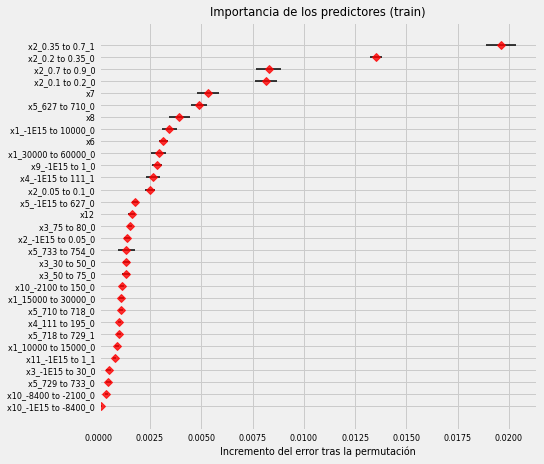

In [47]:
# Gráfico de la importancia de cada predictor
fig, ax = plt.subplots(figsize=(7, 7))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación')

